In [35]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import coremltools as ct

In [36]:
class BasicCNNDiffActivFunc(nn.Module):
    def __init__(self):
        super(BasicCNNDiffActivFunc, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)
 
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 36)  
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = self.pool(torch.tanh(self.conv3(x)))
        x = x.view(-1, 128 * 3 * 3)
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = BasicCNNDiffActivFunc()
model.to(device)
print(model)

mps
BasicCNNDiffActivFunc(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [37]:
model.load_state_dict(torch.load("assignment2_part3.h5"))

<All keys matched successfully>

In [38]:
device = 'cpu'
model.to(device)

BasicCNNDiffActivFunc(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [53]:
data_dir = '/Users/Downloads/cnn_dataset/'  # Change this to the path of your root directory

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.Grayscale(),       
    transforms.ToTensor(),       
    transforms.Normalize((0.5,), (0.5,))  
])


dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

tensor([ 9, 23, 14, 12, 34, 16,  2,  4, 24, 34, 22,  2, 26, 34,  0, 14,  1, 34,
         4, 12, 14,  7, 23,  4, 13, 31, 14, 17, 33, 10, 28, 35, 17, 27,  0,  4,
         1, 12, 26, 35, 18,  2, 20, 11, 11,  0, 33,  0, 33, 16,  6,  7, 12, 13,
        26,  6, 10, 16, 32,  2, 24, 35, 12, 26])


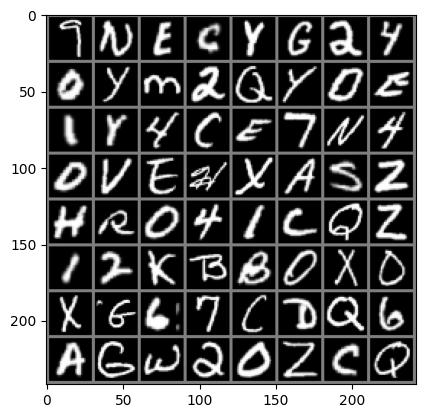

In [54]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
print(labels)
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [55]:
model.eval()

BasicCNNDiffActivFunc(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Label: 29


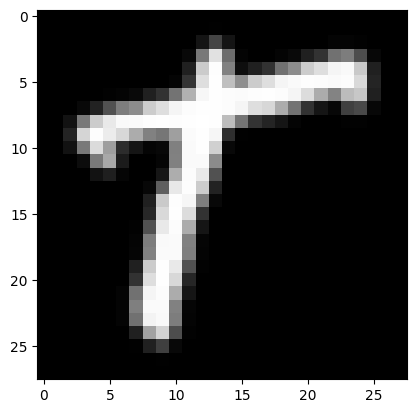

In [56]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
idx = np.random.randint(images.size(0))
image = images[idx]
label = labels[idx]
print("Label:", label.item())
image_np = image.numpy().squeeze()

# Denormalize the image data (assuming you used normalization in your transform)
image_np = 0.5 * image_np + 0.5

# Display the image
plt.imshow(image_np, cmap='gray')
plt.show()

# Add an extra batch dimension to the image to match the expected input shape for the model
image = image.unsqueeze(0)

# Move the input to the device
image = image.to(device)

In [58]:
traced_model = torch.jit.trace(model, image)

In [59]:
import coremltools as ct

# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=image.shape)]
 )

Running MIL default pipeline:   0%|          | 0/71 [00:00<?, ? passes/s]/Users/gokulp/anaconda3/envs/myenv2/lib/python3.8/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 6009.03 passes/s]


In [60]:
# Save the converted model.
model.save("newmodel.mlpackage")